# Travel Planner

A simple implementation with routing

In [120]:
import os
from dotenv import load_dotenv
from typing import Any, Dict, List, Optional, Literal, Set, TypedDict
from pydantic import BaseModel, Field, ValidationError
from IPython.display import display, Image
# LangGraph StateGraph import (assume installed)
from langgraph.graph import StateGraph, START, END

# LangChain imports (LLM & Chains)
from langchain_openai import ChatOpenAI
from langchain import LLMChain, PromptTemplate
from langchain.output_parsers import PydanticOutputParser

# Tavily search
from langchain_tavily import TavilySearch

In [3]:
load_dotenv()

True

In [72]:
# Setup LLM clients using env keys
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
if not OPENAI_API_KEY:
    raise RuntimeError("OPENAI_API_KEY not set in environment. Set it in .env or env vars before running.")

llm = ChatOpenAI(model="gpt-4", temperature=0.0)

In [7]:
# Setup Tavily client (assume TAVILY_API_KEY present)
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
if not TAVILY_API_KEY:
    raise RuntimeError("TAVILY_API_KEY not set in environment. Set it in .env or env vars before running.")

# instantiate tool
tavily_tool = TavilySearch()

In [161]:
class Constraints(BaseModel):
    origin: Optional[str] = None
    city: Optional[str] = None
    date: Optional[str] = None
    return_date: Optional[str] = None
    days: Optional[int] = None
    budget_per_person: Optional[float] = None
    interests: Optional[str] = None
    transport_constraints: Optional[Dict[str, Any]] = None
    hotel_constraints: Optional[Dict[str, Any]] = None

class TransportOption(BaseModel):
    provider: str
    mode: str
    depart: str
    arrive: str
    duration_min: int
    price_per_person: float
    notes: Optional[str] = None

class HotelOption(BaseModel):
    name: str
    rating: Optional[float]
    price_per_night: float
    distance_from_center_km: Optional[float]
    amenities: List[str] = Field(default_factory=list)
    notes: Optional[str] = None

class ItineraryItem(BaseModel):
    day: int
    morning: str
    afternoon: str
    evening: str
    notes: Optional[str] = None

class Intention(BaseModel):
    type: Literal["travel_plan","hotel_only","transport_only","unrelated"]

class PlannerState(TypedDict):
    goal: str
    intent: Optional[str]
    constraints: Optional[Constraints] = None
    # subtasks: List[Subtask] = Field(default_factory=list)
    # policy: Dict[str, Any] = Field(default_factory=lambda: {"max_retries": 2, "worker_timeout": 12.0})
    final_plan: Optional[Dict[str, Any]]

In [162]:
# Supervisor LLM with intentation output
supervisor_llm = llm.with_structured_output(Intention)

/home/argha-ds/datascience/langgraph-agents/.venv/lib/python3.12/site-packages/langchain_openai/chat_models/base.py:1928: UserWarning: Cannot use method='json_schema' with model gpt-4 since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


In [163]:
# Supervisor prompt to classify user intent
supervisor_prompt = PromptTemplate(
    input_variables=["goal"],
    template=(
        "You are an expert supervisor of a Travel Planner"
        "Classify the user's travel planning intent based on the goal below.\n"
        "Possible intents are:\n"
        "1. travel_plan - planning a full trip\n"
        "2. hotel_only - only looking for hotel options\n"
        "3. transport_only - only looking for transport options\n"
        "4. unrelated - not related to travel planning or transport booking or hotel booking\n\n"
        "Goal: {goal}\n"
        "Respond with the intent type only."
    )
)

# Supervisor chain
supervisor_chain = supervisor_prompt | supervisor_llm

# Planner promt and chain
constraints_parser = PydanticOutputParser(pydantic_object=Constraints)
format_instructions = constraints_parser.get_format_instructions()

planner_prompt_template = f"""
You are an assistant that extracts travel constraints from a user query.
Return ONLY valid JSON that matches the Constraints model below.

Constraints model:
  "origin": string or null,
  "city": string or null,
  "date": string (YYYY-MM-DD) or null,
  "return_date": string (YYYY-MM-DD) or null,
  "days": integer or null,
  "budget_per_person": float or null,
  "interests": string or null,
  "transport_constraints": object or null,
  "hotel_constraints": object or null


User query:
{{text}}

Respond ONLY with valid JSON matching the model above. Do not include any explanation, markdown, or extra text.
"""

planner_prompt = PromptTemplate(
    input_variables=["text"],
    template=planner_prompt_template
)
planner_chain = planner_prompt | llm

In [164]:
# Define supervisor node function
def supervisor_node(state: PlannerState) -> PlannerState:
    goal = state.get("goal")
    if not goal:
        raise ValueError("Goal is required in the state.")

    result = supervisor_chain.invoke({"goal": goal})
    print(f"Supervisor raw output: {result.type}")
    try:
        
        return {
            "goal": goal,
            "intent": result.type,
            "final_plan": None
        }
    except ValidationError as e:
        print(f"Validation error parsing intention: {e}")
        return {
            "goal": goal,
            "intent": "unrelated",
            "final_plan": None
        }

In [165]:
# Define supervisor gate
def supervisor_gate(state: PlannerState) -> Literal["plan", "unrelated"]:
    if state.get("intent") in ["travel_plan", "hotel_only", "transport_only"]:
        return "plan"
    return "unrelated"

In [166]:
def planner_node(state: PlannerState) -> PlannerState:
    goal = state.get("goal")
    if not goal:
        raise ValueError("Goal is required in the state.")

    try:
        constraints = planner_chain.invoke({"text": goal})
        print(constraints)
    except Exception as e:
        print("Extractor parse error:", e)
        constraints = Constraints()
    return {
        "goal": state["goal"],
        "intent": state["intent"],
        "constraints": constraints,
        "final_plan": {"message": "Planning logic not yet implemented."}
    }

In [167]:
# Define end unrelated node
def end_unrelated_node(state: PlannerState) -> PlannerState:
    return {
        "goal": state["goal"],
        "intent": state["intent"],
        "final_plan": {"message": "The request was unrelated to travel planning."}
    }

In [168]:
# Build and complile the state graph
builder = StateGraph(PlannerState)

# Add nodes
builder.add_node("supervisor", supervisor_node)
builder.add_node("planner", planner_node)
builder.add_node("end_unrelated", end_unrelated_node)

# Add edges
builder.add_edge(START, "supervisor")
builder.add_conditional_edges("supervisor", supervisor_gate, {
    "plan": "planner",
    "unrelated": "end_unrelated"
})
builder.add_edge("planner", END)
builder.add_edge("end_unrelated", END)

# Compile the graph
graph = builder.compile()

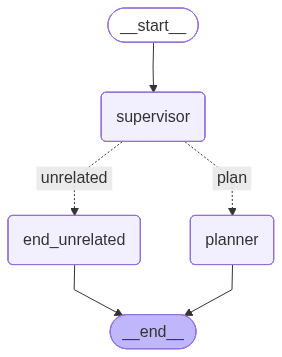

In [28]:
# Display mermaid diagram
display(Image(graph.get_graph().draw_mermaid_png()))

In [169]:
# Test the graph with a travel planning goal
input_text = "Plan a 2-day trip to Varanasi for two adults from Asansol"
initial_state = {
    "goal": input_text,
    "intent": None,
    "final_plan": None
}
result = graph.invoke(initial_state)
print(result)

Supervisor raw output: travel_plan
content='{\n  "origin": "Asansol",\n  "city": "Varanasi",\n  "date": null,\n  "return_date": null,\n  "days": 2,\n  "budget_per_person": null,\n  "interests": null,\n  "transport_constraints": null,\n  "hotel_constraints": null\n}' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 69, 'prompt_tokens': 166, 'total_tokens': 235, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4-0613', 'system_fingerprint': None, 'id': 'chatcmpl-CFEoX3u8OpHj15c7fFlqR6hqaXrXF', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--f579b245-d6ab-4a00-adab-849aedc48aab-0' usage_metadata={'input_tokens': 166, 'output_tokens': 69, 'total_tokens': 235, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio'

In [170]:
# Test the graph for transport only
input_text= "I want to go to Mumbai on 2nd October, 2025. What are the convenient ways?"
result = graph.invoke({"goal": input_text})
print(result)

Supervisor raw output: travel_plan
content='{\n  "origin": null,\n  "city": "Mumbai",\n  "date": "2025-10-02",\n  "return_date": null,\n  "days": null,\n  "budget_per_person": null,\n  "interests": null,\n  "transport_constraints": null,\n  "hotel_constraints": null\n}' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 70, 'prompt_tokens': 170, 'total_tokens': 240, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4-0613', 'system_fingerprint': None, 'id': 'chatcmpl-CFEp02kPIU7lVHNhkT1M42h1RIXi2', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--cb1f3408-ab2c-485b-a1e2-e1af57392cc2-0' usage_metadata={'input_tokens': 170, 'output_tokens': 70, 'total_tokens': 240, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'au

In [171]:
# Test the graph for hotel only
input_text= "I want to go to Mumbai on 2nd October, 2025. Where should I stay?"
result = graph.invoke({"goal": input_text})
print(result)

Supervisor raw output: hotel_only
content='{\n  "origin": null,\n  "city": "Mumbai",\n  "date": "2025-10-02",\n  "return_date": null,\n  "days": null,\n  "budget_per_person": null,\n  "interests": null,\n  "transport_constraints": null,\n  "hotel_constraints": null\n}' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 70, 'prompt_tokens': 169, 'total_tokens': 239, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4-0613', 'system_fingerprint': None, 'id': 'chatcmpl-CFEpS904xodHbX6TDKnjauRHm1QzC', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--b5a9a729-0991-41ca-9e7a-914f66c05c5d-0' usage_metadata={'input_tokens': 169, 'output_tokens': 70, 'total_tokens': 239, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'aud

In [172]:
# Test the graph for unrelated
input_text= "What is the capital of Maharashtra?"
result = graph.invoke({"goal": input_text})
print(result)

Supervisor raw output: unrelated
{'goal': 'What is the capital of Maharashtra?', 'intent': 'unrelated', 'final_plan': {'message': 'The request was unrelated to travel planning.'}}
